# **EDA-Exploratory Data Analysis** 

**In this notebook we work with the normalized dataset**

In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['font.size'] = 7.0

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics.pairwise import cosine_distances


pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)
PATH="C:\\Users\\c.manganaro\\Desktop\\TESI\\sample\\datasets\\SWaT\\normalized"
PLOT=True;

In [2]:
df = pd.read_csv(PATH+'\\normalized.csv',parse_dates=['Timestamp'])

## **Preliminary steps:**

**Optimize the memory allocation**

In [3]:
float64_cols = df.select_dtypes(include=['float64']).columns
df[float64_cols] = df[float64_cols].astype('float32')
int64_cols = df.select_dtypes(include=['int64']).columns
df[int64_cols] = df[int64_cols].astype('int32')
print(df.dtypes)

Timestamp         datetime64[ns]
Machine_Status            object
FIT101                   float32
LIT101                   float32
AIT201                   float32
AIT202                   float32
AIT203                   float32
FIT201                   float32
DPIT301                  float32
FIT301                   float32
LIT301                   float32
AIT401                   float32
AIT402                   float32
FIT401                   float32
LIT401                   float32
AIT501                   float32
AIT502                   float32
AIT503                   float32
AIT504                   float32
FIT501                   float32
FIT502                   float32
FIT503                   float32
FIT504                   float32
PIT501                   float32
PIT502                   float32
PIT503                   float32
FIT601                   float32
MV101                      int32
P101                       int32
P102                       int32
MV201     

In [4]:
df.loc[df['Machine_Status'] == 'Normal', 'Machine_Status'] = 0
df.loc[df['Machine_Status'] == 'Attack', 'Machine_Status'] = 1
df['Machine_Status'] = df['Machine_Status'].astype(int)

In [5]:
df.dropna(subset=['Machine_Status'], inplace=True)

**Set TimeStamp as Dataframe index**

In [6]:
df.set_index('Timestamp', inplace=True)

**Select only 2015 year**

In [7]:
df = df.loc[df.index.year == 2015]

## **Graphical EDA**

In [8]:
df.Machine_Status.value_counts()

0    755203
1     49316
Name: Machine_Status, dtype: int64

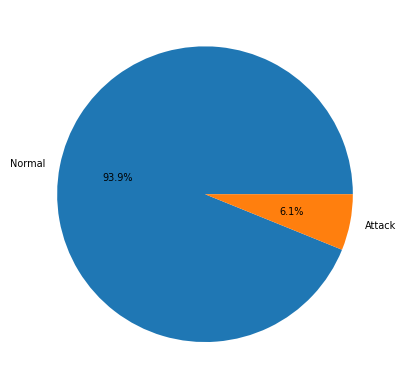

In [9]:
status = ["Normal","Attack"]
sizes = df.Machine_Status.value_counts()

plt.pie(x=sizes,labels=status, autopct='%1.1f%%')
plt.show()

**Extract only numerical features in order to plot graphically the anomalies**

In [10]:
cat_col = []
num_col = []

for column in df.columns:
    unique_values = df[column].nunique()
    if unique_values > 10:
        num_col.append(column)
    else:
        cat_col.append(column)

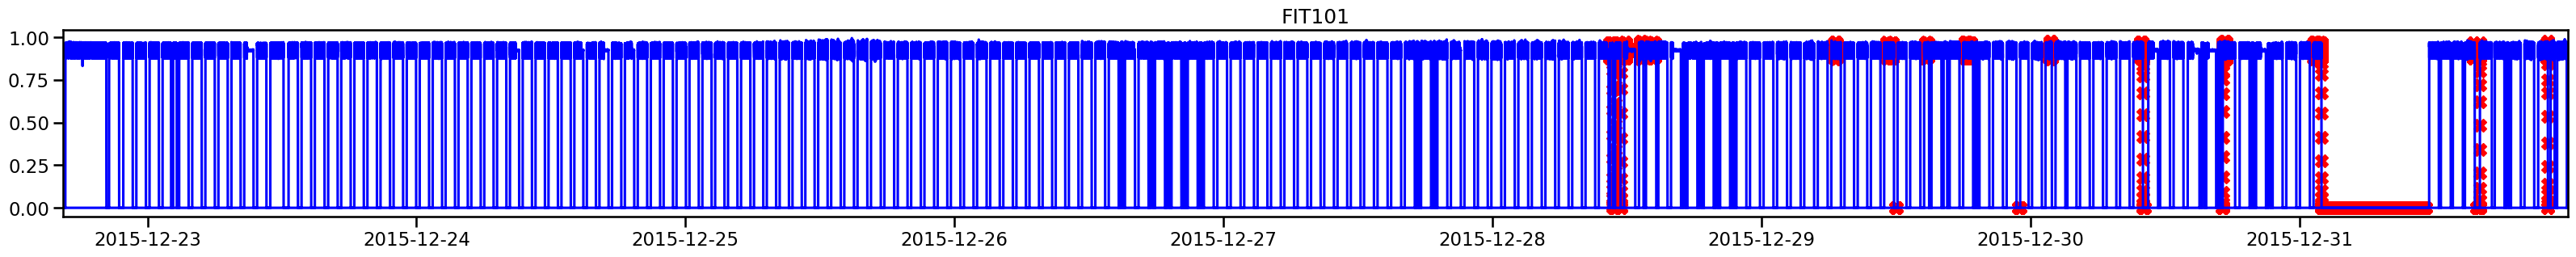

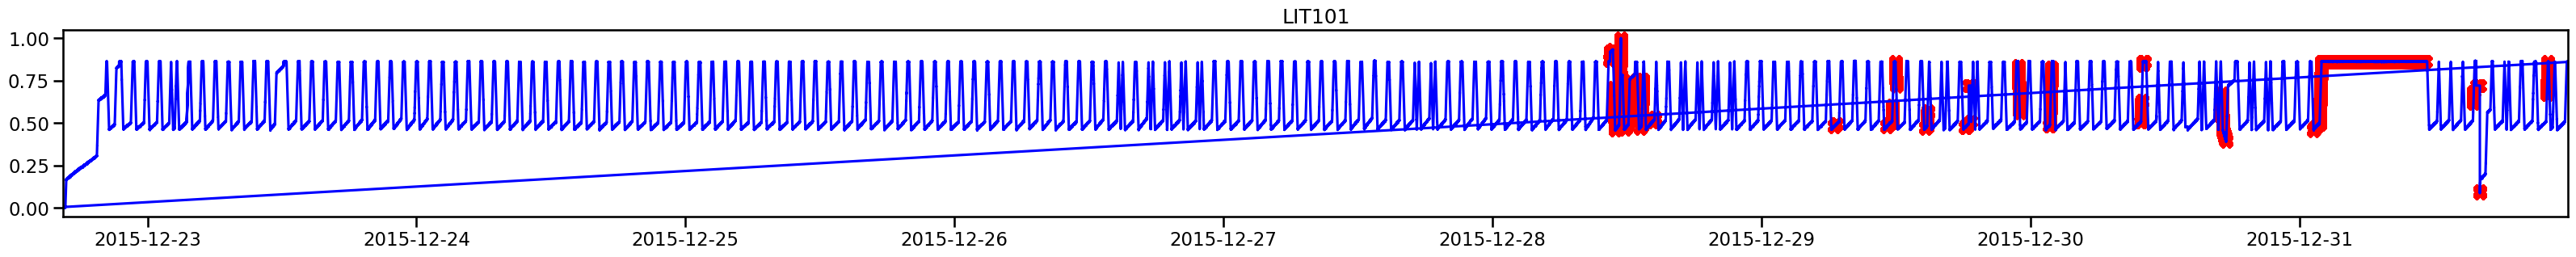

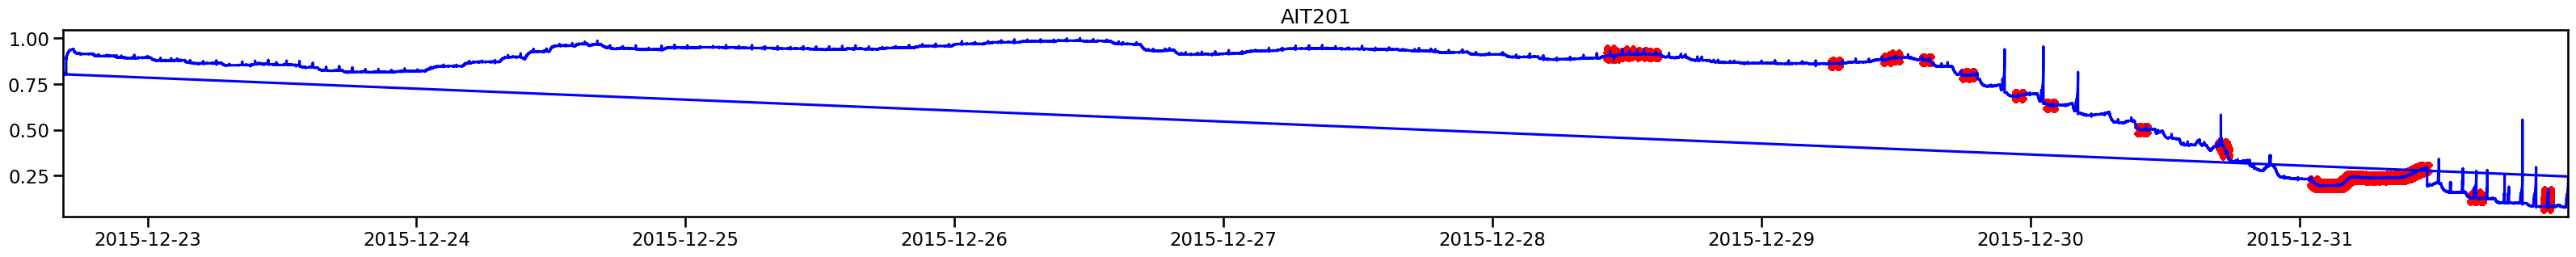

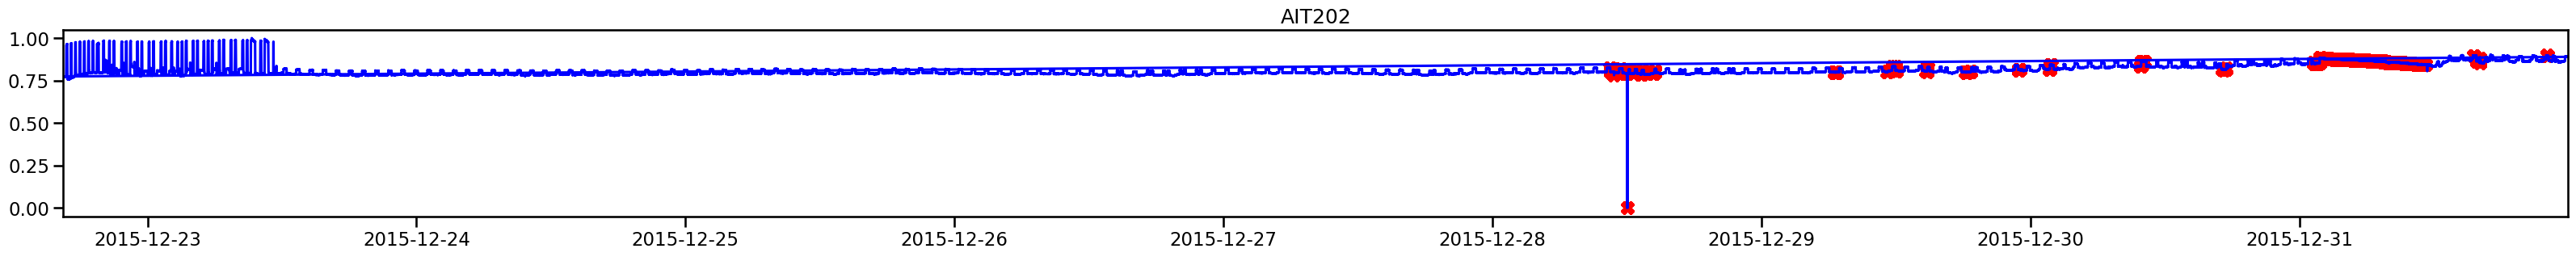

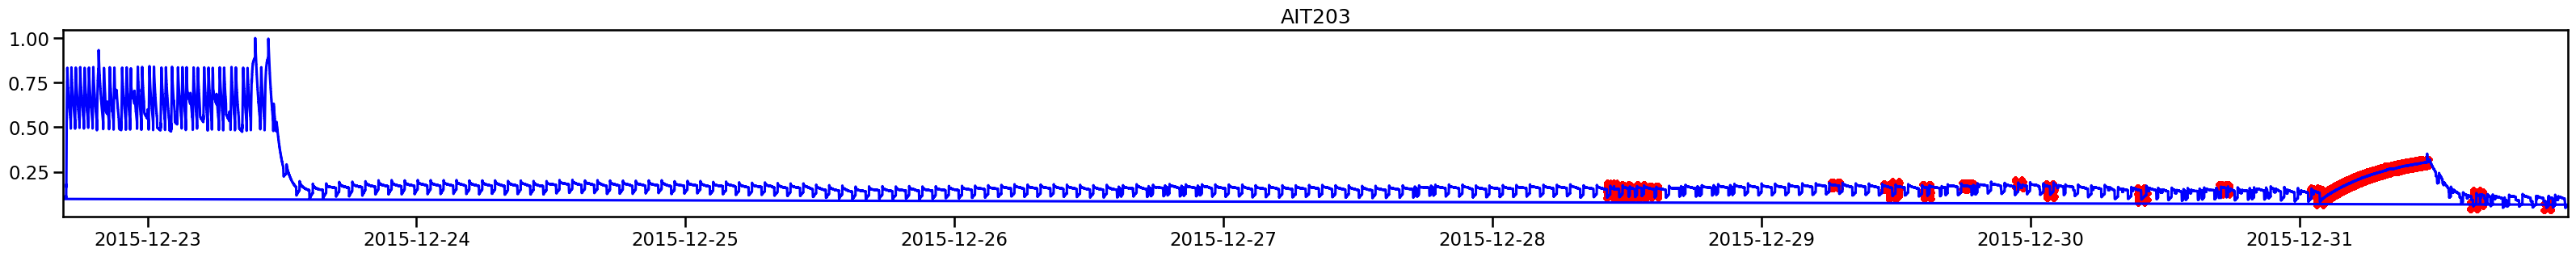

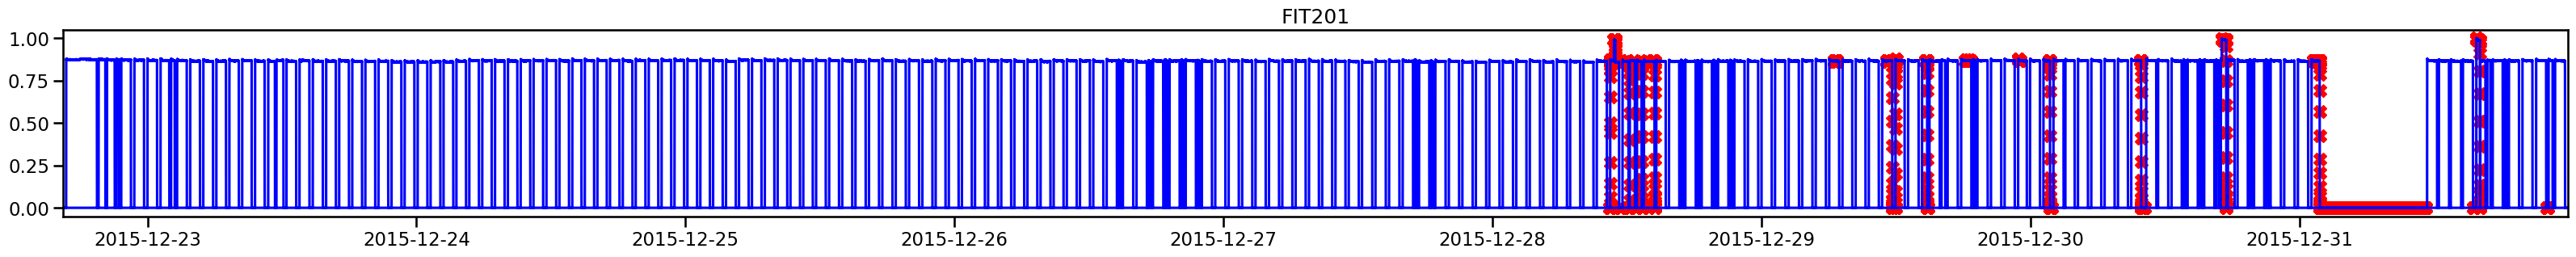

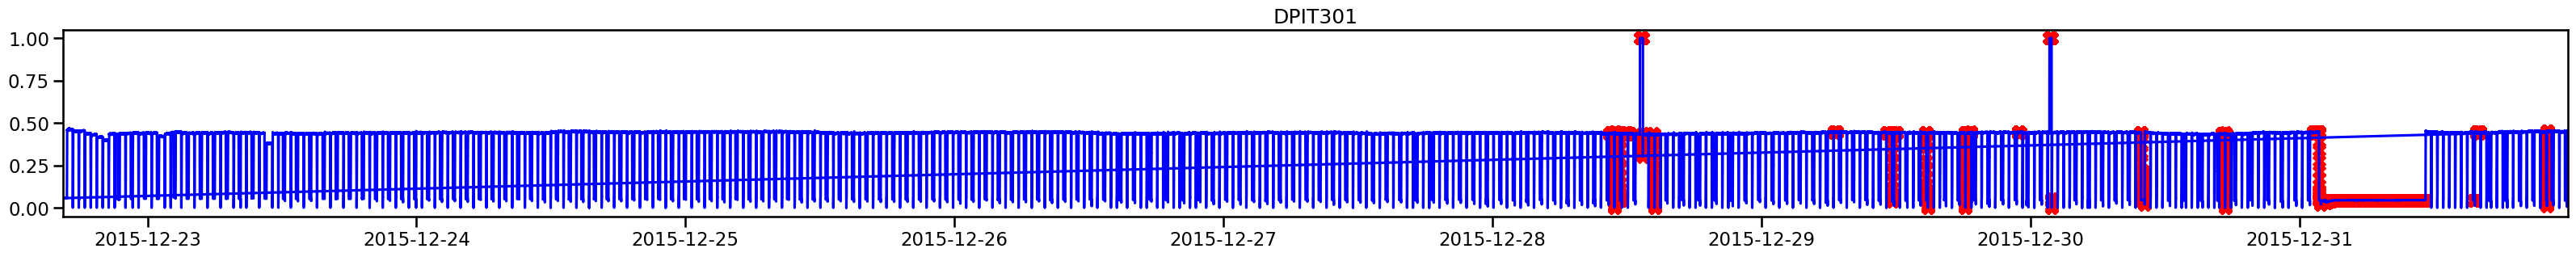

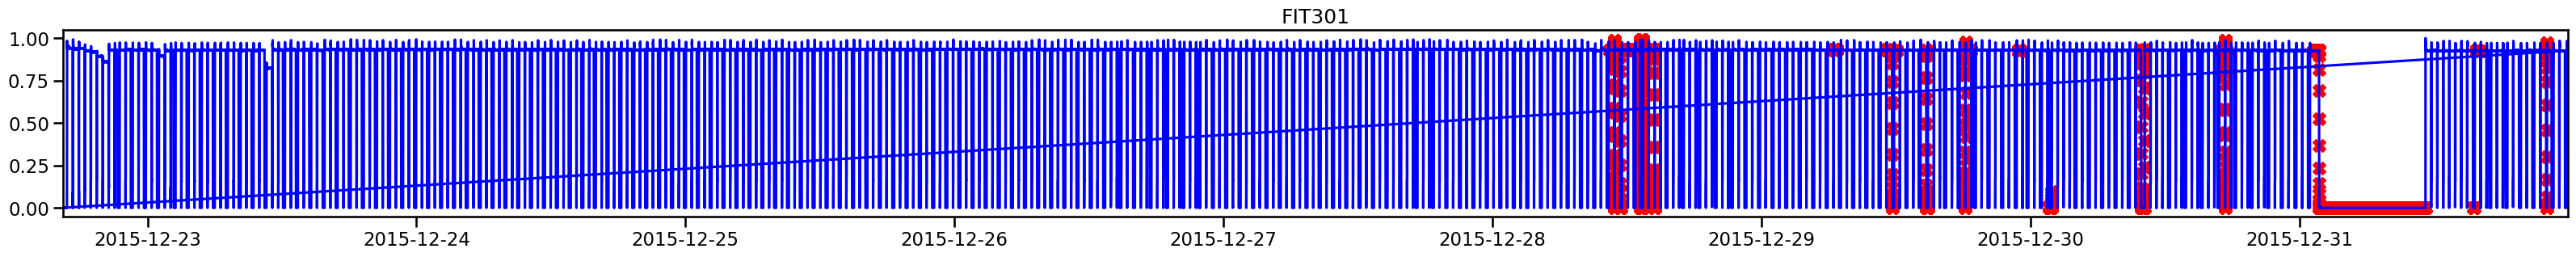

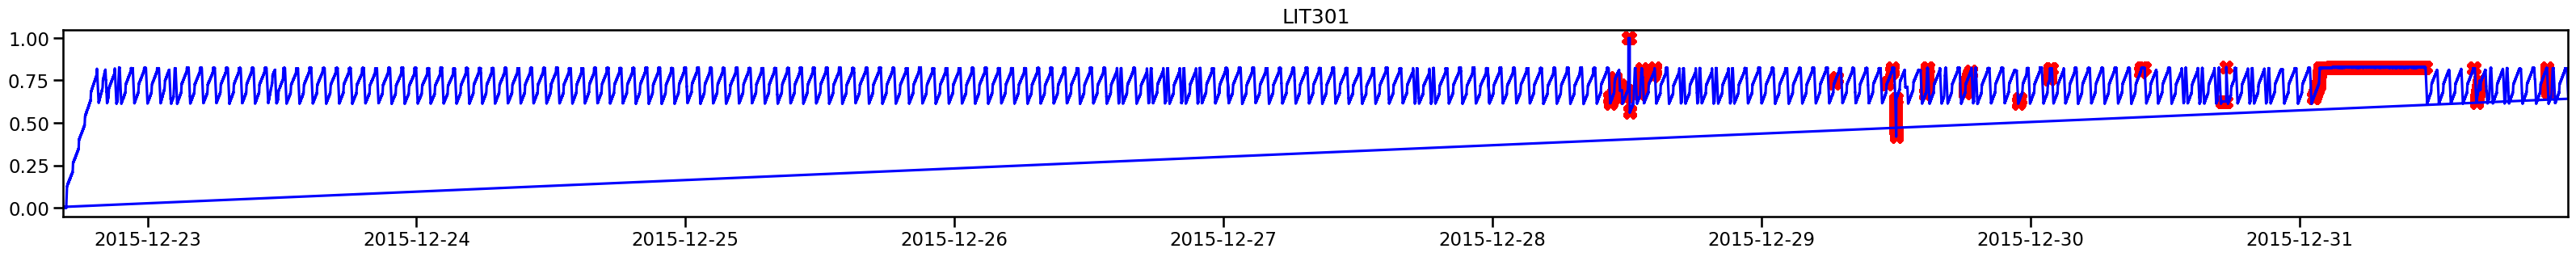

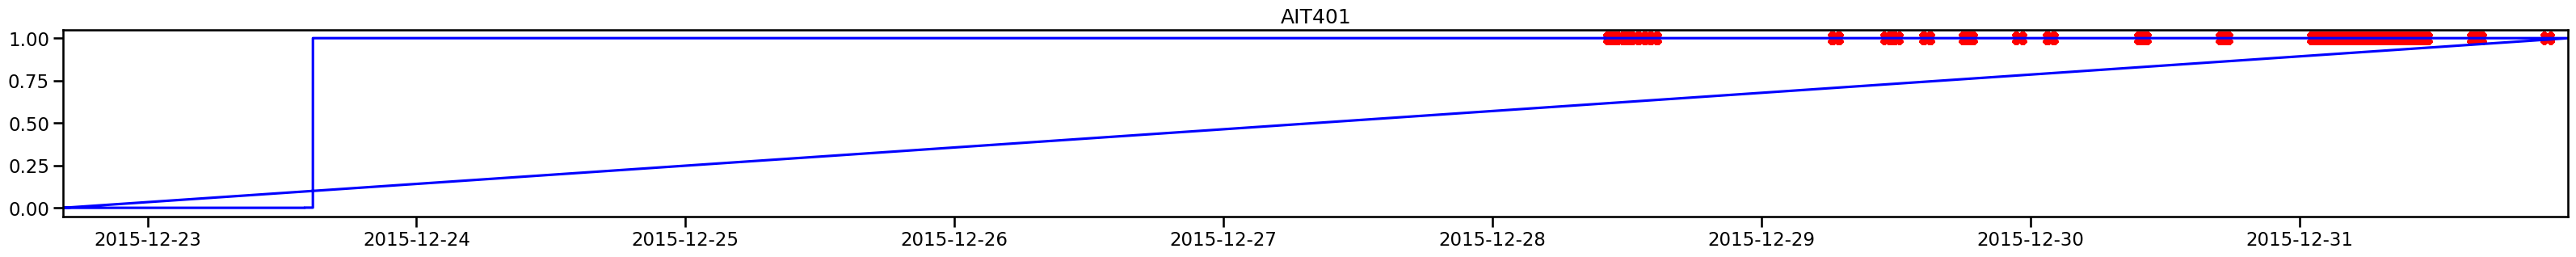

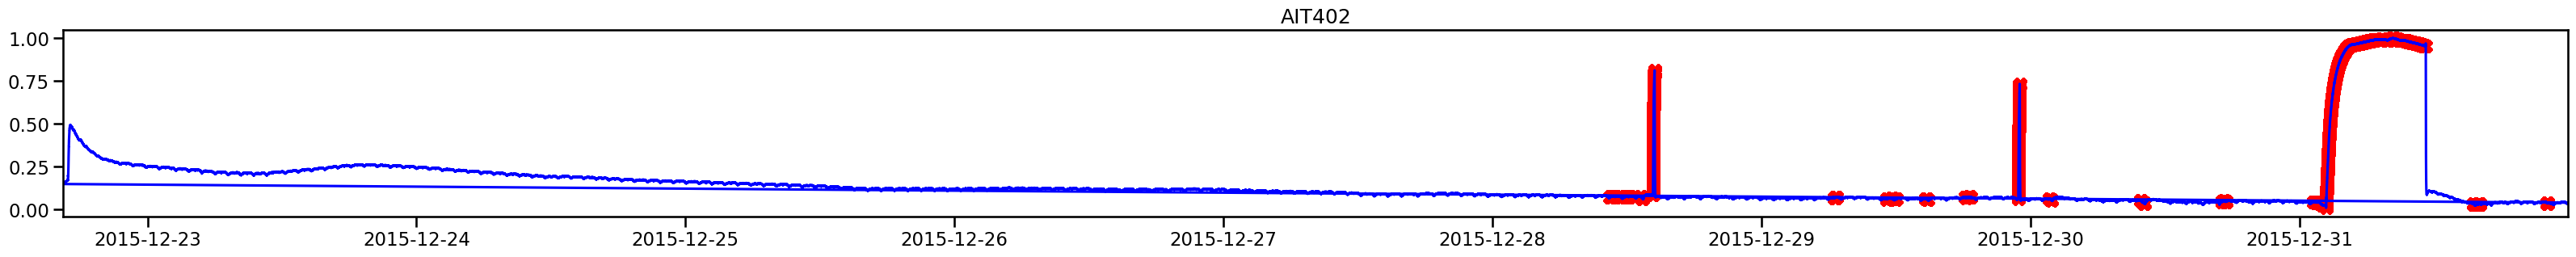

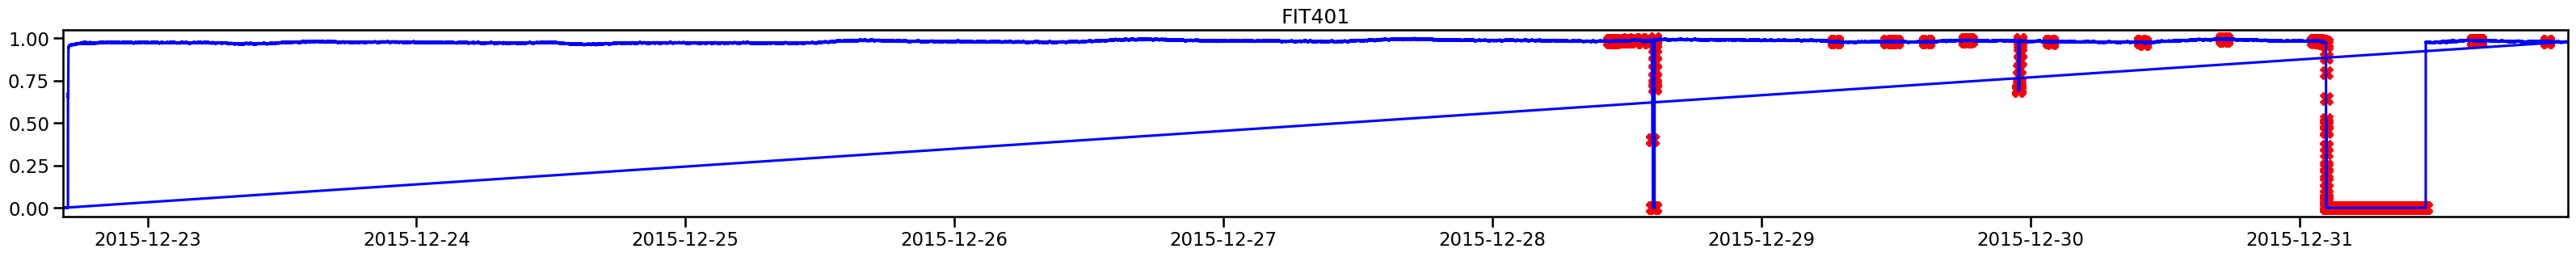

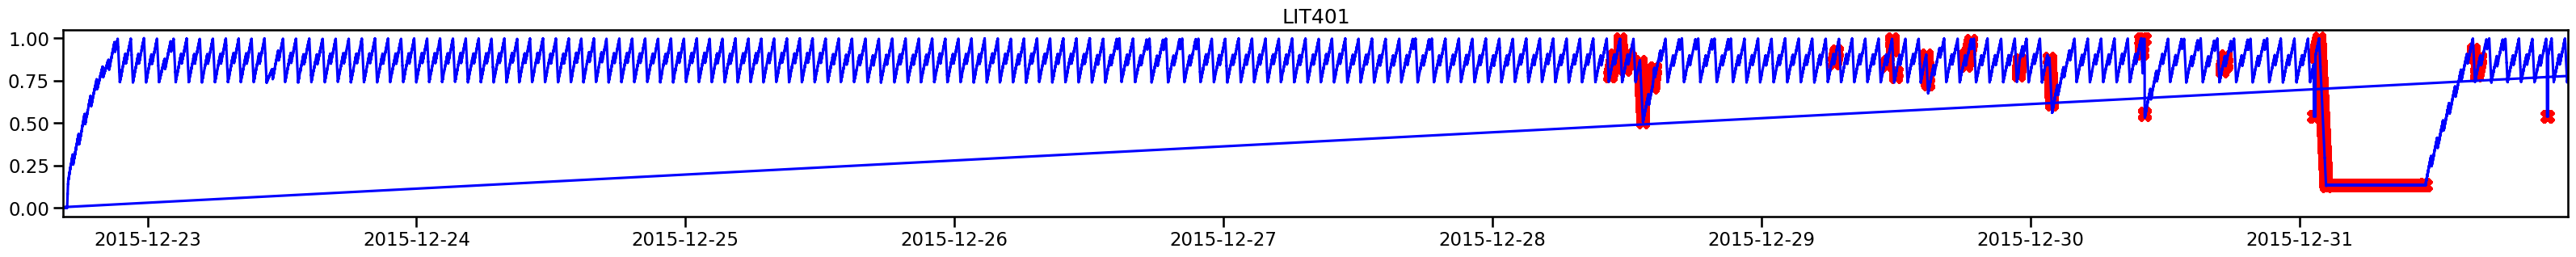

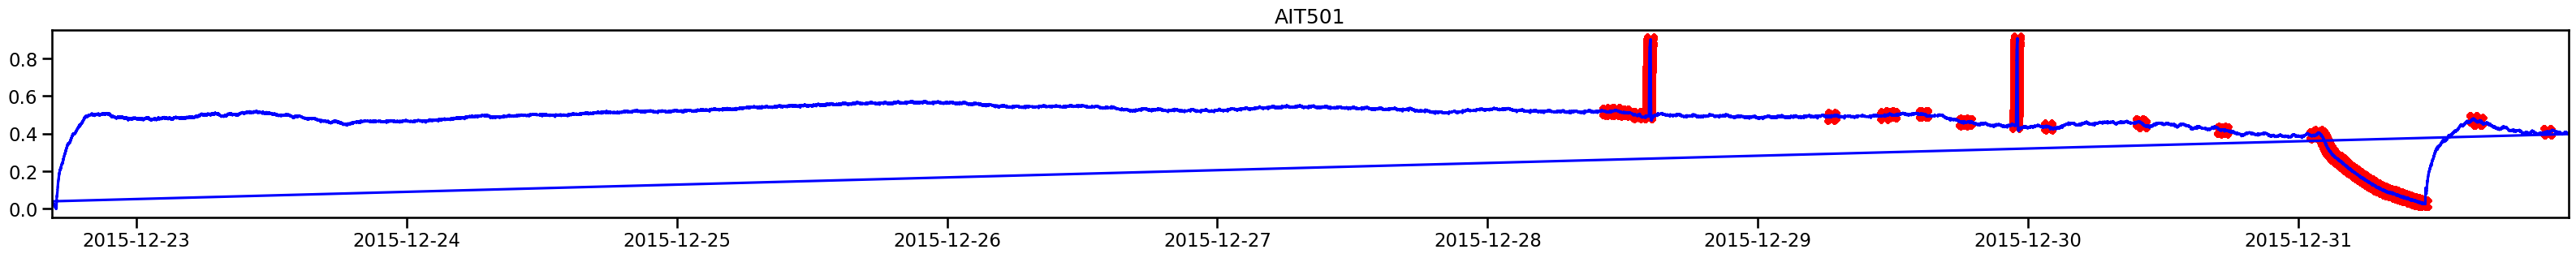

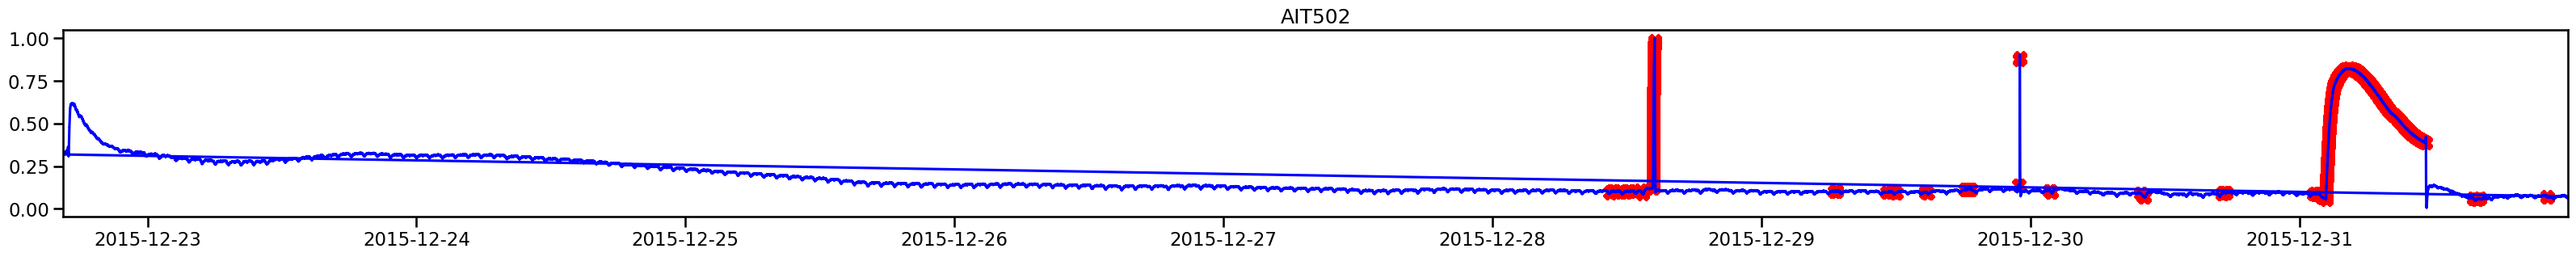

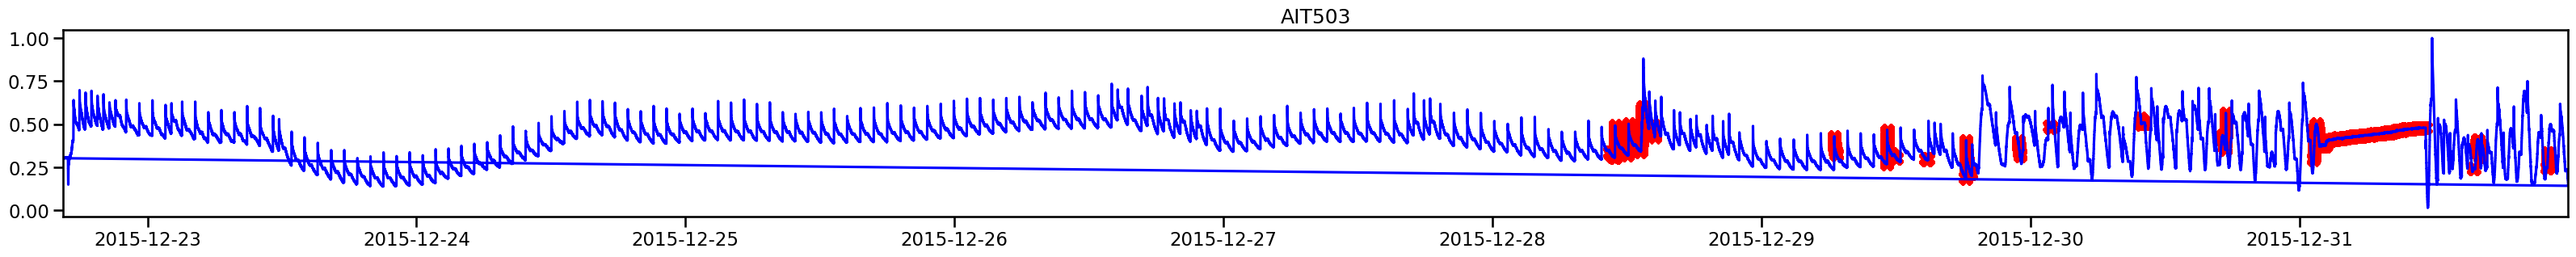

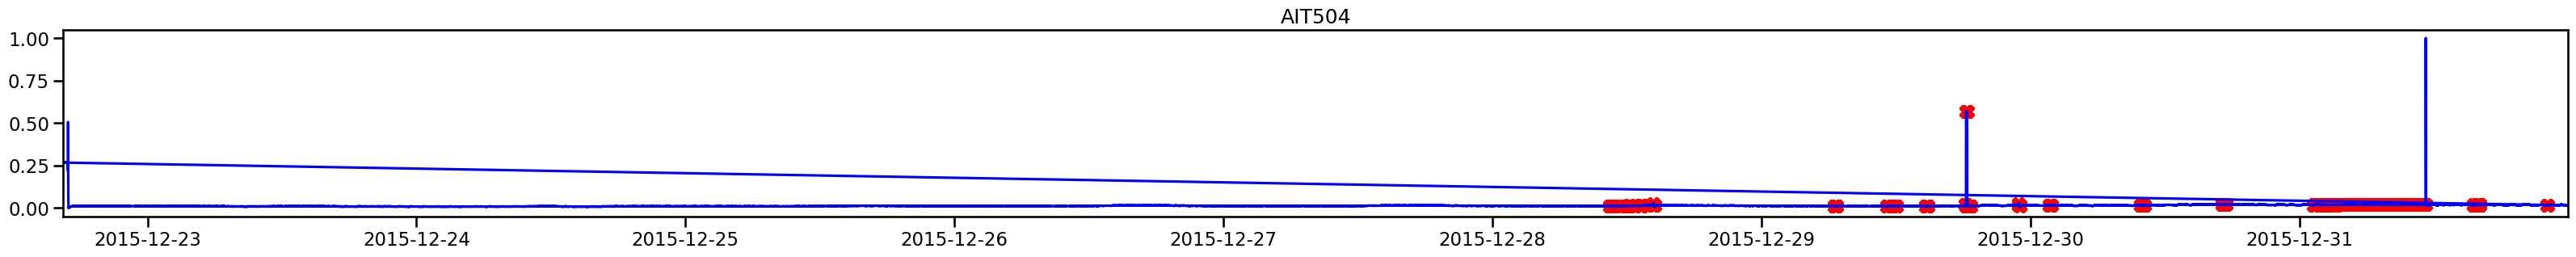

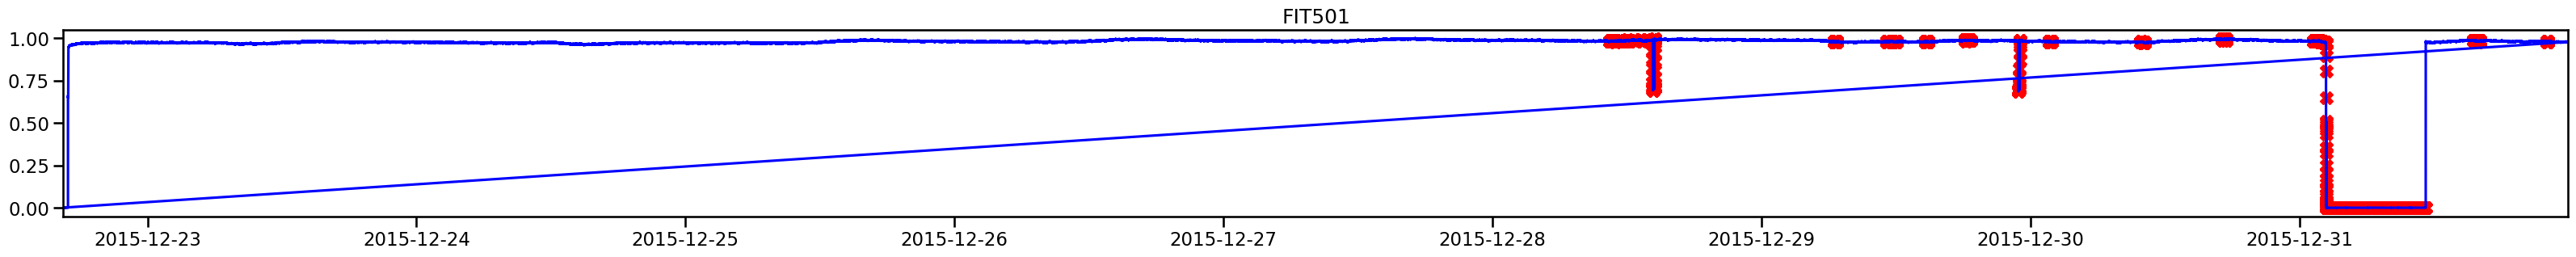

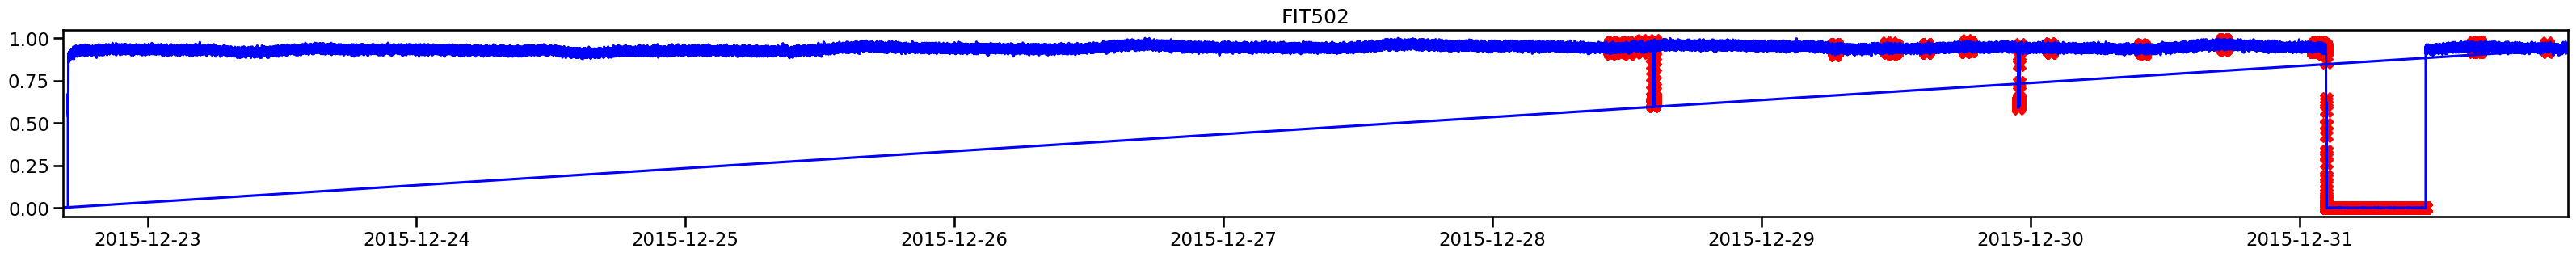

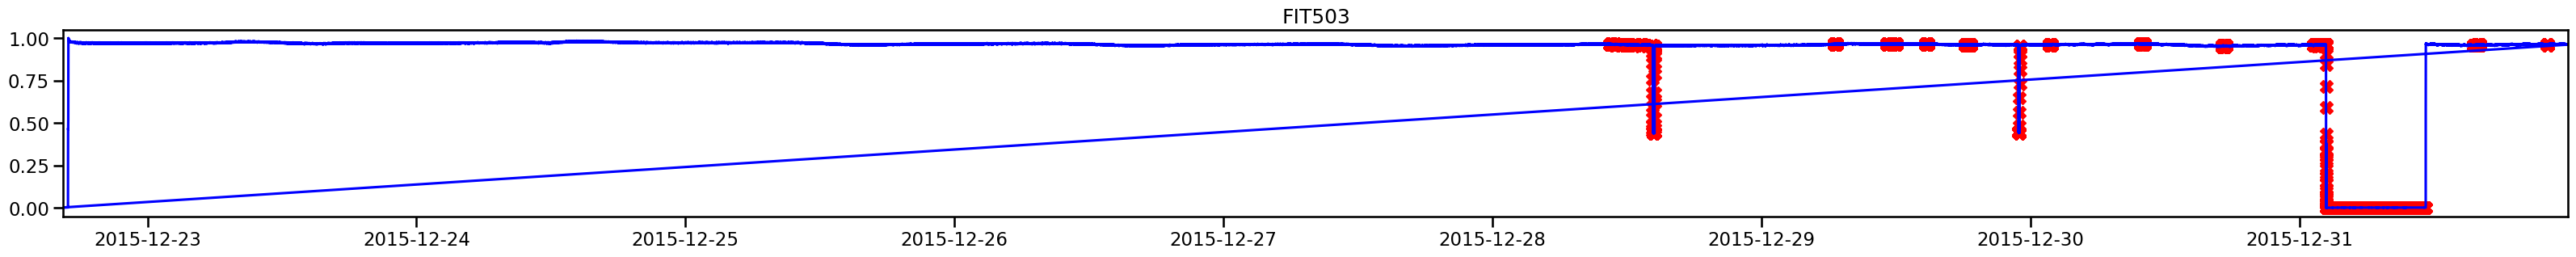

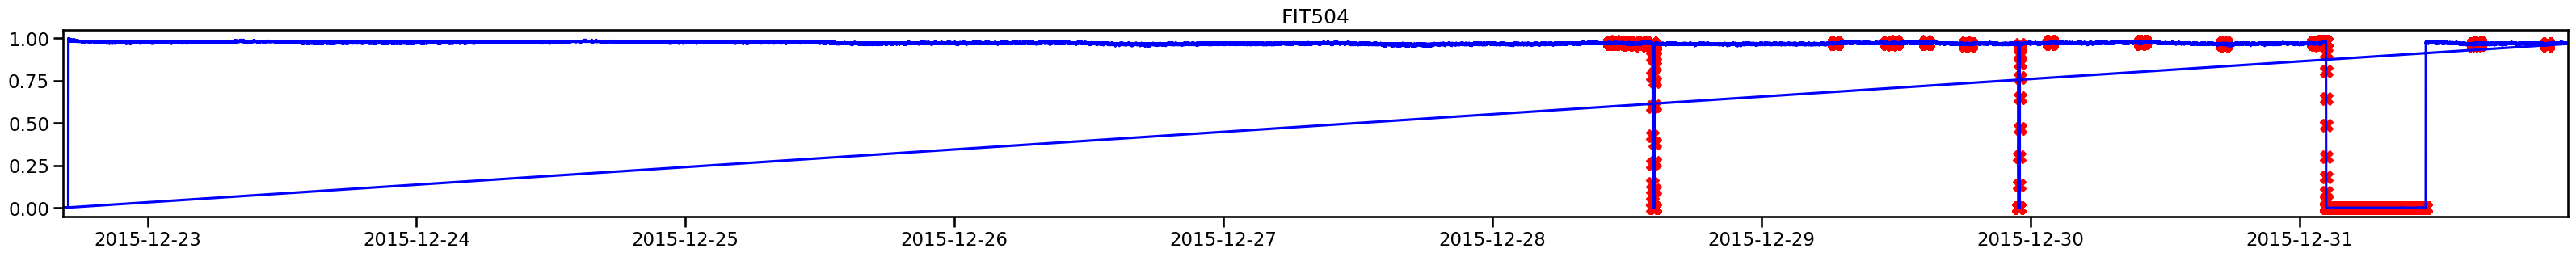

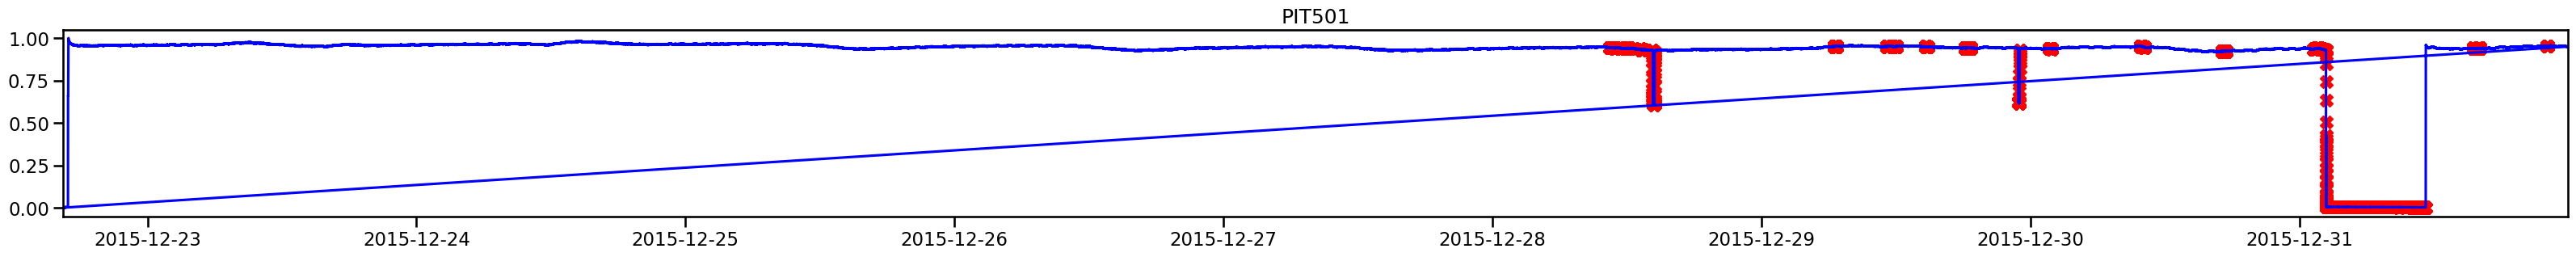

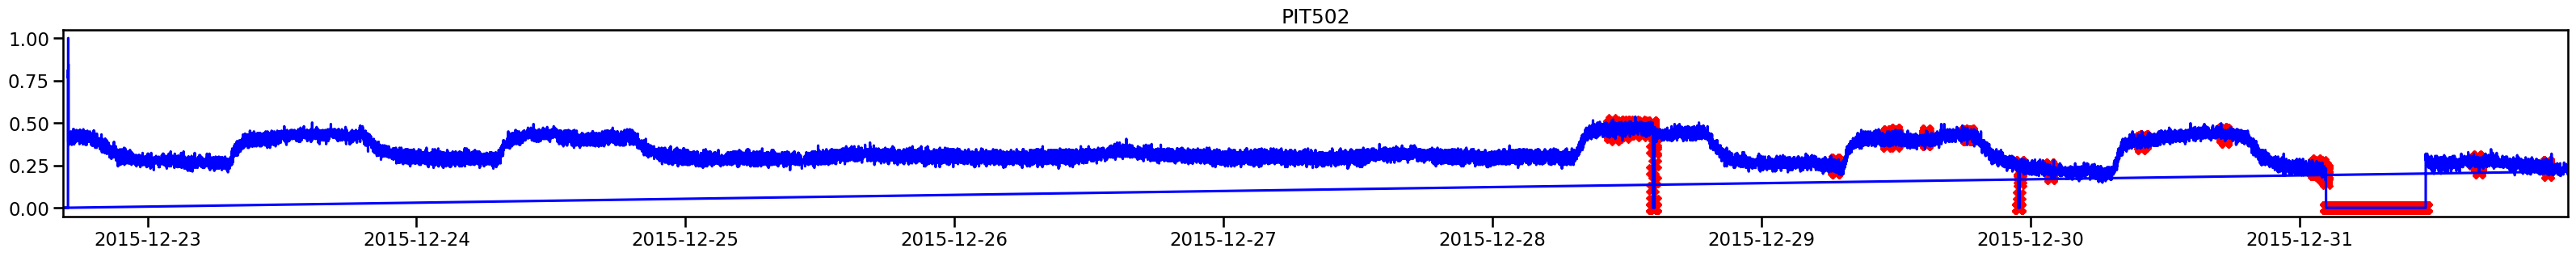

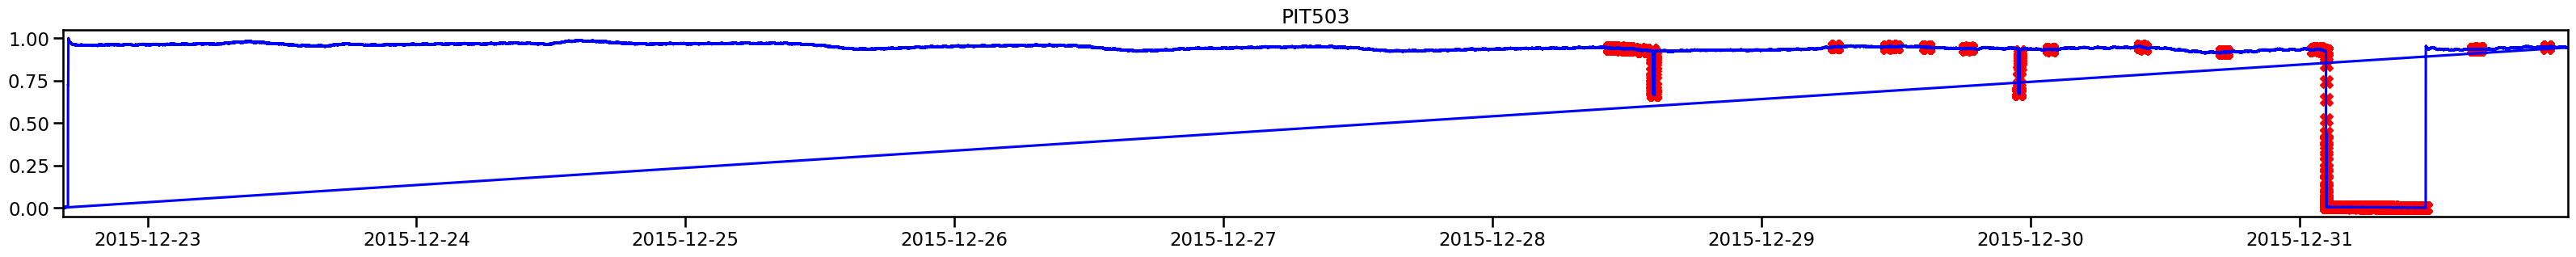

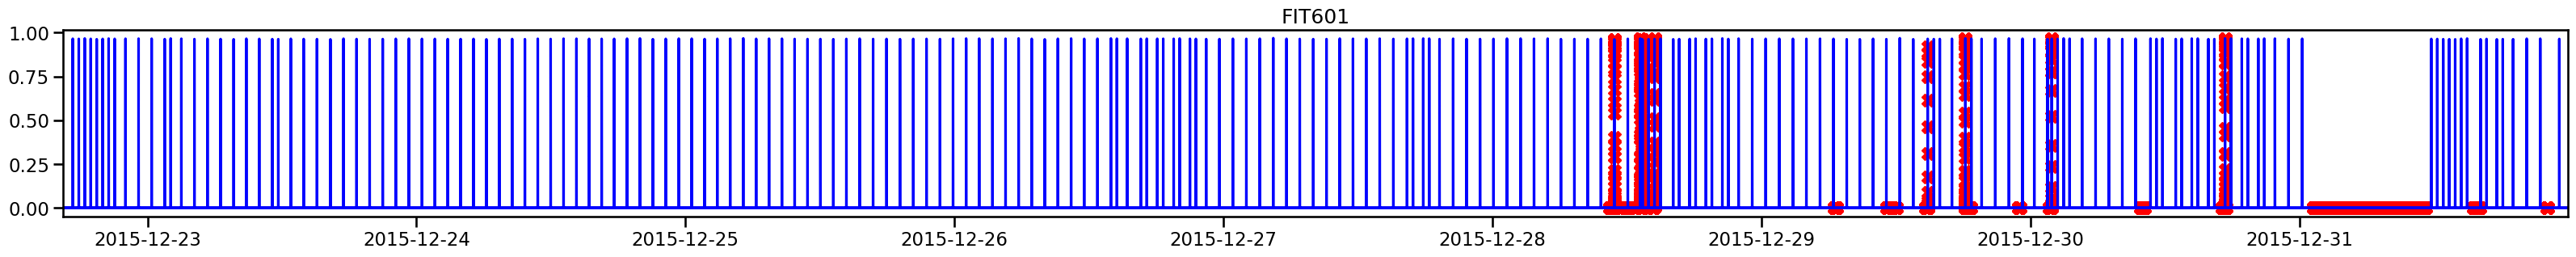

In [11]:
if PLOT:
    # create a directory to save the plots
    if not os.path.exists('plots'):
        os.makedirs('plots')

    # extract the Attack status
    attack = df[df['Machine_Status'] == 1]

    # extract the names of the numerical columns
    df2 = df.drop(['Machine_Status'], axis=1)
    names = num_col

    # plot time series for each sensor with Attack state marked with X in red color
    for name in names:
        sns.set_context('talk')
        fig, ax = plt.subplots(figsize=(40, 3))
        ax.plot(attack[name], linestyle='none', marker='X', color='red', markersize=12)
        ax.plot(df[name], color='blue')
        ax.set_title(name)
        ax.set_xlim(df.index.min(), df.index.max())
        fig.savefig(f'plots/{name}.png', bbox_inches='tight')
        plt.show()

## **PCA**

In order to proceed with Kmeans clustering, since we have a large amount of features and sensors it is considered appropriate in order to reduce noise apply pca to avoid the problem of "curse of dimensionality". <br>
*Keep in mind that the data are already normalized.* <br>
In addition to that, only numerical features have been considered.

In [12]:
df_numeric = df.loc[:, num_col]

In [13]:
df_numeric.head()

,FIT101,LIT101,AIT201,AIT202,AIT203,FIT201,DPIT301,FIT301,LIT301,AIT401,AIT402,FIT401,LIT401,AIT501,AIT502,AIT503,AIT504,FIT501,FIT502,FIT503,FIT504,PIT501,PIT502,PIT503,FIT601
Timestamp,,,,,,,,,,,,,,,,,,,,,,,,,
2015-12-28 10:00:00,0.879322,0.500023,0.899417,0.801947,0.153462,0.865044,0.438853,0.928726,0.770793,0.999677,0.079038,0.980350,0.929175,0.521646,0.106829,0.375534,0.010781,0.980677,0.939528,0.962783,0.970903,0.946126,0.449782,0.944116,0.000071
2015-12-28 10:00:01,0.886285,0.500072,0.899417,0.801947,0.153462,0.865044,0.438853,0.929319,0.770793,0.999677,0.079038,0.981743,0.929131,0.521646,0.106829,0.375534,0.010781,0.980677,0.952695,0.962783,0.970903,0.946126,0.449782,0.944521,0.000071
2015-12-28 10:00:02,0.901833,0.500023,0.899417,0.801304,0.153462,0.863956,0.437572,0.929480,0.771093,0.999677,0.079038,0.981743,0.928955,0.521646,0.106829,0.375534,0.010781,0.980458,0.950061,0.962783,0.973530,0.946188,0.449782,0.944521,0.000071
2015-12-28 10:00:03,0.918195,0.500170,0.899417,0.801304,0.153462,0.863956,0.437572,0.929480,0.771393,0.999677,0.079038,0.981010,0.928867,0.521646,0.106112,0.375534,0.010781,0.980458,0.940656,0.962783,0.973530,0.946188,0.449782,0.944197,0.000071
2015-12-28 10:00:04,0.930842,0.500804,0.899417,0.801304,0.153462,0.864228,0.437572,0.929480,0.771655,0.999677,0.079038,0.981010,0.929351,0.521646,0.105216,0.375534,0.010781,0.980458,0.940656,0.962783,0.973530,0.946188,0.449782,0.943629,0.000071


In [14]:
pca = PCA()
pca.fit(df_numeric)

PCA()

**Plot the principal components in order to choose the right number of features**

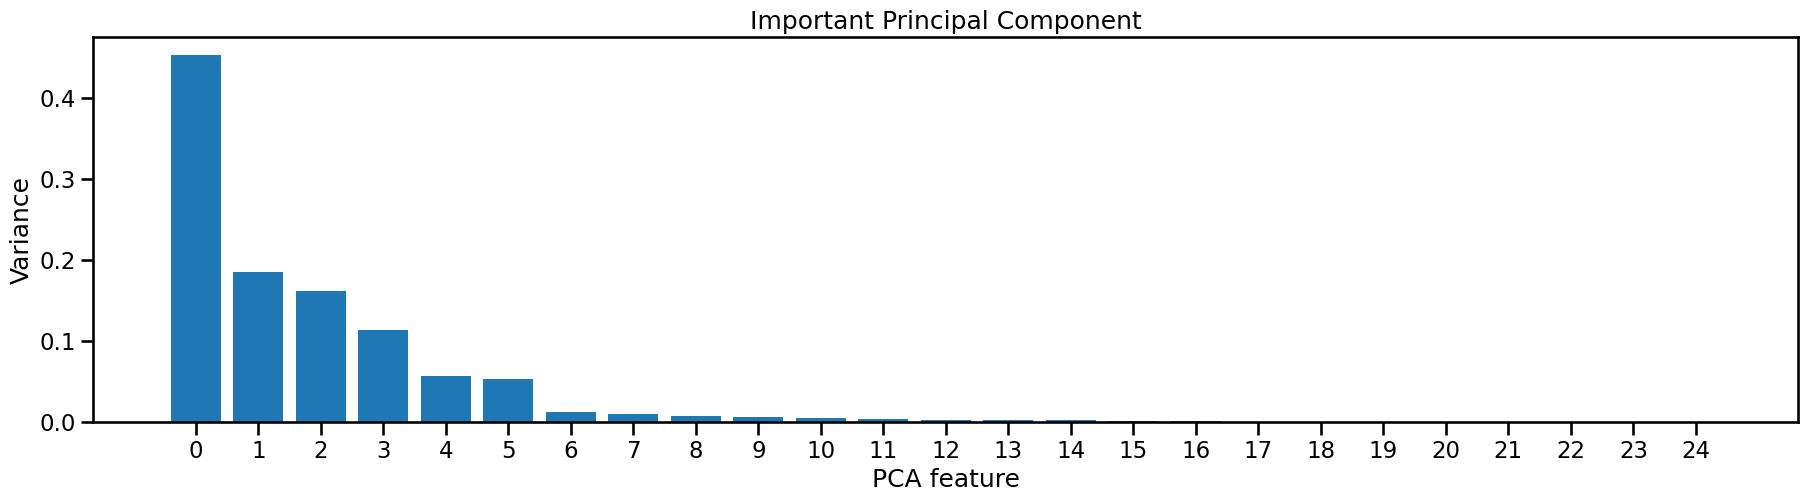

In [15]:
features = range(pca.n_components_)
_=plt.figure(figsize=(22,5))
_=plt.bar(features,pca.explained_variance_)
_=plt.xlabel('PCA feature')
_=plt.ylabel('Variance')
_=plt.xticks(features)
_=plt.title('Important Principal Component')
plt.show()

--> **From the plot above we can see that only three feature have a significant variance**

**Calculate PCA with 3 components**

In [16]:
pca = PCA(n_components=3)
pComponents = pca.fit_transform(df_numeric)
principal_df = pd.DataFrame(data = pComponents,columns=['pca1','pca2', 'pca3'])

In [17]:
principal_df.head()

,pca1,pca2,pca3
0,-0.401033,0.028029,0.172480
1,-0.407145,0.033159,0.172901
2,-0.411300,0.045088,0.178797
3,-0.413663,0.056861,0.187601
4,-0.417585,0.066093,0.192928


## **Elbow Method**

The **Elbow Method** is a graphical representation of finding the optimal ‘K’ in a K-means clustering. <br>
It works by finding **WCSS** (Within-Cluster Sum of Square) i.e. the sum of the square distance between points in a cluster and the cluster centroid.

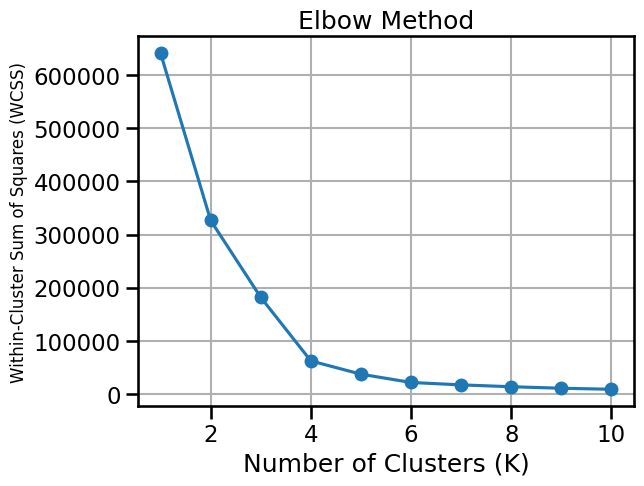

In [18]:
# Initialize lists to store WCSS values for different K
wcss = []

# Define a range of K values
k_range = range(1, 11)

# Calculate WCSS for each K
for k in k_range:
    kmeans = KMeans(n_clusters=k, n_init=10,random_state=42)
    kmeans.fit(principal_df.values)
    wcss.append(kmeans.inertia_)


plt.plot(k_range, wcss, marker='o')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)', fontsize=12)
plt.title('Elbow Method')
plt.grid()
plt.show()

--> **From the Elbow method plot above, we can see that the choice falls into 3 or 4 clusters.**

**Trying with n_clusters=3**

## **KMeans**

In [19]:
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(principal_df.values)
cluster_centers = kmeans.cluster_centers_
labels = kmeans.predict(principal_df.values)
unique_elements, counts_elements = np.unique(labels, return_counts=True)
clusters = np.asarray((unique_elements, counts_elements))

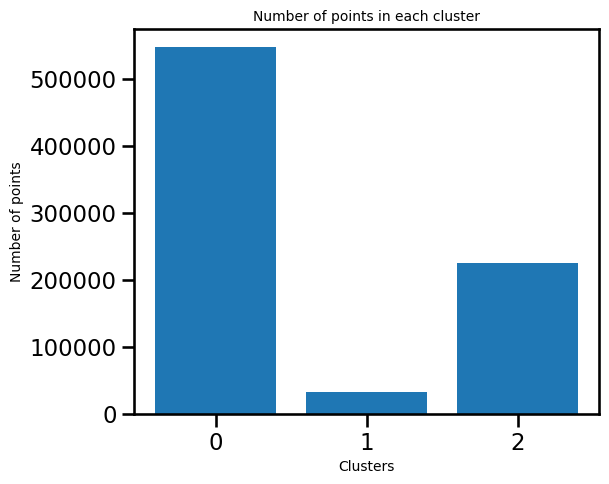

In [20]:
_ = plt.figure(figsize=(6, 5))
_ = plt.bar(range(len(clusters[0])), clusters[1], tick_label=clusters[0])
_ = plt.xlabel('Clusters', fontsize=10)
_ = plt.ylabel('Number of points', fontsize=10)
_ = plt.title('Number of points in each cluster', fontsize=10)
plt.show()


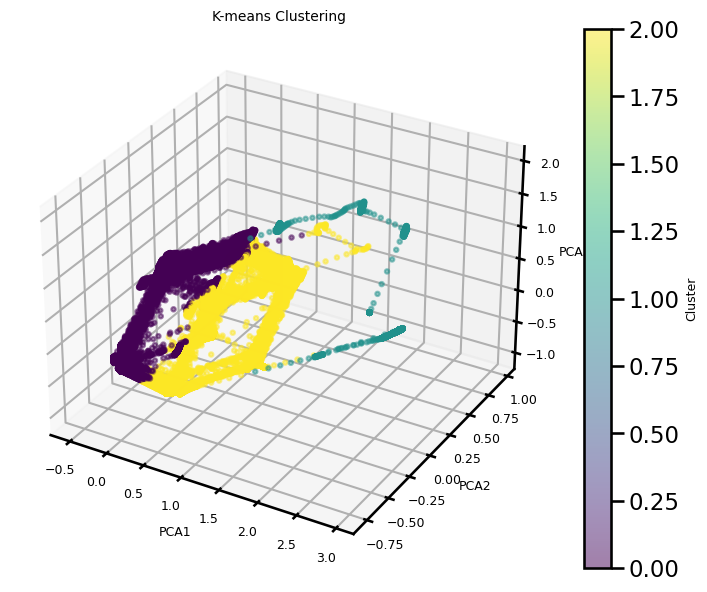

In [21]:
if PLOT:
    fig = plt.figure(figsize=(9, 7))
    ax = fig.add_subplot(111, projection='3d')

    scatter = ax.scatter(principal_df['pca1'], principal_df['pca2'], principal_df['pca3'], c=labels, cmap='viridis', s=10, alpha=0.5)

    ax.tick_params(axis='x', labelsize=9)
    ax.tick_params(axis='y', labelsize=9)
    ax.tick_params(axis='z', labelsize=9)

    ax.set_xlabel('PCA1', fontsize=9)
    ax.set_ylabel('PCA2', fontsize=9)
    ax.set_zlabel('PCA3', fontsize=9)
    ax.set_title('K-means Clustering', fontsize=10)

    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label('Cluster', fontsize=9)

    plt.rcParams['figure.dpi'] = 150
    plt.show()

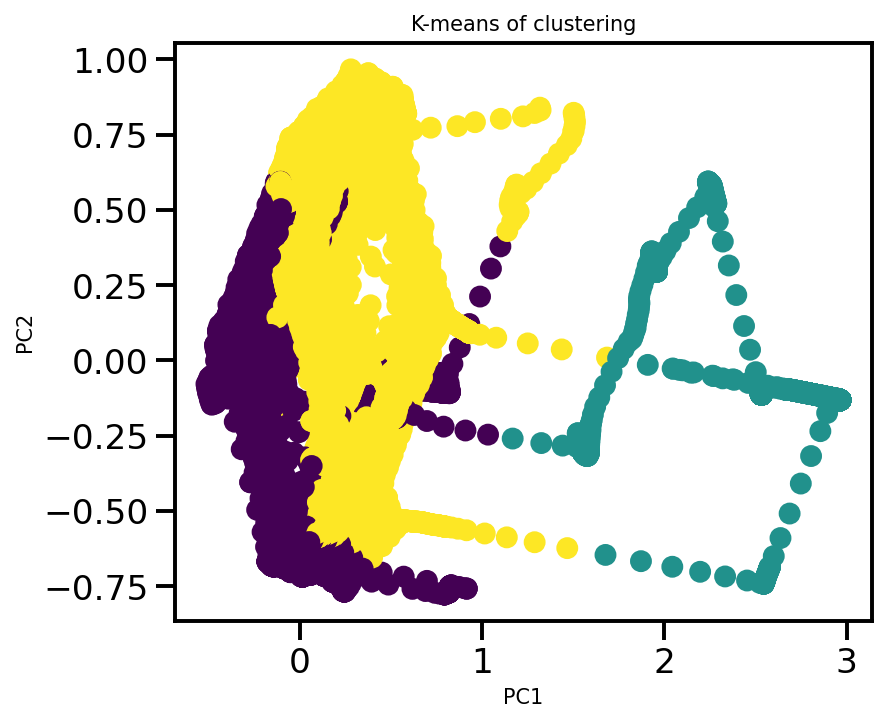

In [22]:
if PLOT:
    _ = plt.figure(figsize=(6,5))
    _ = plt.scatter(principal_df['pca1'], principal_df['pca2'], c=labels)
    _ = plt.xlabel('PC1', fontsize=10)
    _ = plt.ylabel('PC2', fontsize=10)
    _ = plt.title('K-means of clustering', fontsize=10)
    plt.show()

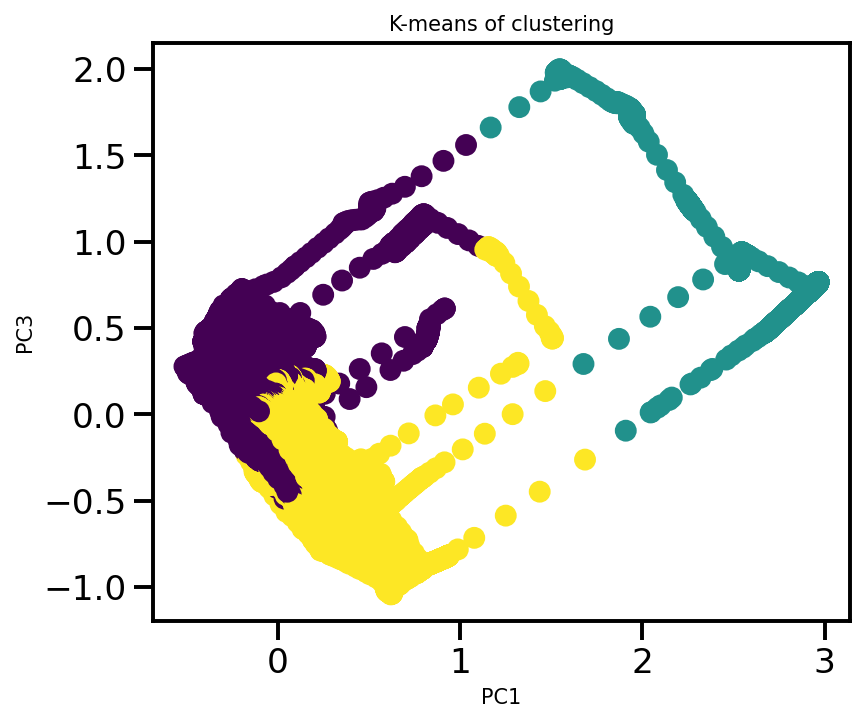

In [23]:
if PLOT:
    _ = plt.figure(figsize=(6,5))
    _ = plt.scatter(principal_df['pca1'], principal_df['pca3'], c=labels)
    _ = plt.xlabel('PC1', fontsize=10)
    _ = plt.ylabel('PC3', fontsize=10)
    _ = plt.title('K-means of clustering', fontsize=10)
    plt.show()

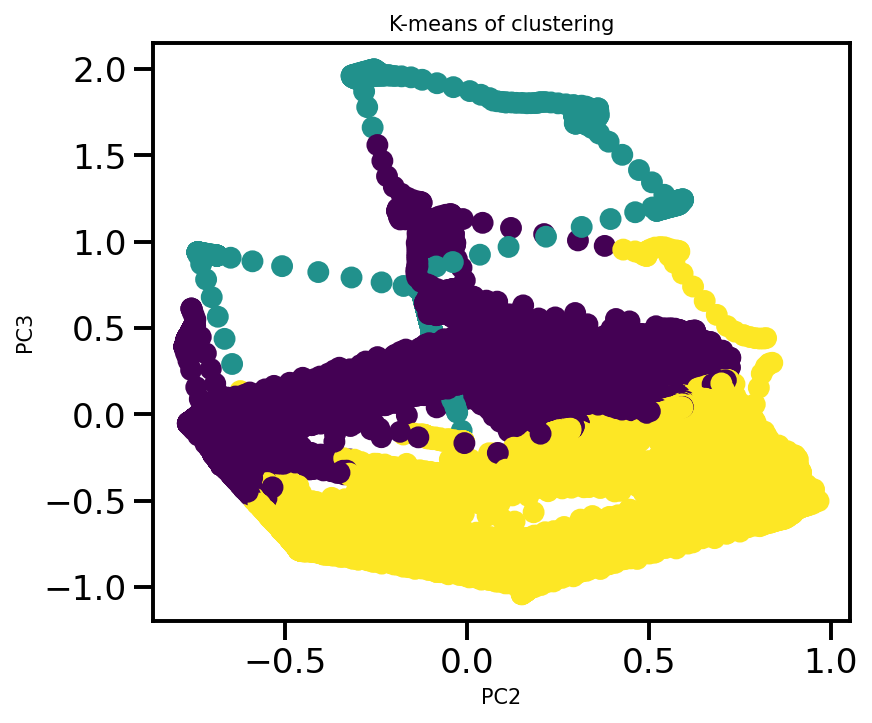

In [24]:
if PLOT:
    _ = plt.figure(figsize=(6,5))
    _ = plt.scatter(principal_df['pca2'], principal_df['pca3'], c=labels)
    _ = plt.xlabel('PC2', fontsize=10)
    _ = plt.ylabel('PC3', fontsize=10)
    _ = plt.title('K-means of clustering', fontsize=10)
plt.show()

**Now compute the distance from the nearest centroid**

**Euclidean Distance**

In [25]:
def getDistanceByPoint(data, model, distance_type):
    """ Function that calculates the distance between a point and centroid of a cluster, 
        returns the distances in a pandas series. 
        distance_type should be 'euclidean' or 'cosine'."""
    
    distance = []
    
    for i in range(0, len(data)):
        Xa = np.array(data.loc[i])
        Xb = model.cluster_centers_[model.labels_[i] - 1]
        
        if distance_type == 'euclidean':
            distance.append(np.linalg.norm(Xa - Xb))
        elif distance_type == 'cosine':
            distance.append(cosine_distances([Xa], [Xb])[0][0])
        else:
            raise ValueError("Invalid distance_type. Use 'euclidean' or 'cosine'.")
    
    return pd.Series(distance, index=data.index)

**set a percentage of anomaly (from the piechart above) in order to choose a threshold and compute the distance of the points from the centroids.**

*cosine takes 6 minutes to compute*

In [26]:
anomaly_fraction =  0.05  # percentage of anomaly in dataset
distance = getDistanceByPoint(principal_df, kmeans, 'euclidean')
number_of_outliers = int(anomaly_fraction * len(distance))
threshold = distance.nlargest(number_of_outliers).min()
principal_df['anomaly'] = (distance >= threshold).astype(int)

In [27]:
principal_df['anomaly'].value_counts()

0    764294
1     40225
Name: anomaly, dtype: int64

In [28]:
principal_df.head()

,pca1,pca2,pca3,anomaly
0,-0.401033,0.028029,0.172480,0
1,-0.407145,0.033159,0.172901,0
2,-0.411300,0.045088,0.178797,0
3,-0.413663,0.056861,0.187601,0
4,-0.417585,0.066093,0.192928,0


In [29]:
df['anomaly'] = pd.Series(principal_df['anomaly'].values, index=df.index)

**Plotting an example with FIT101 SENSOR**

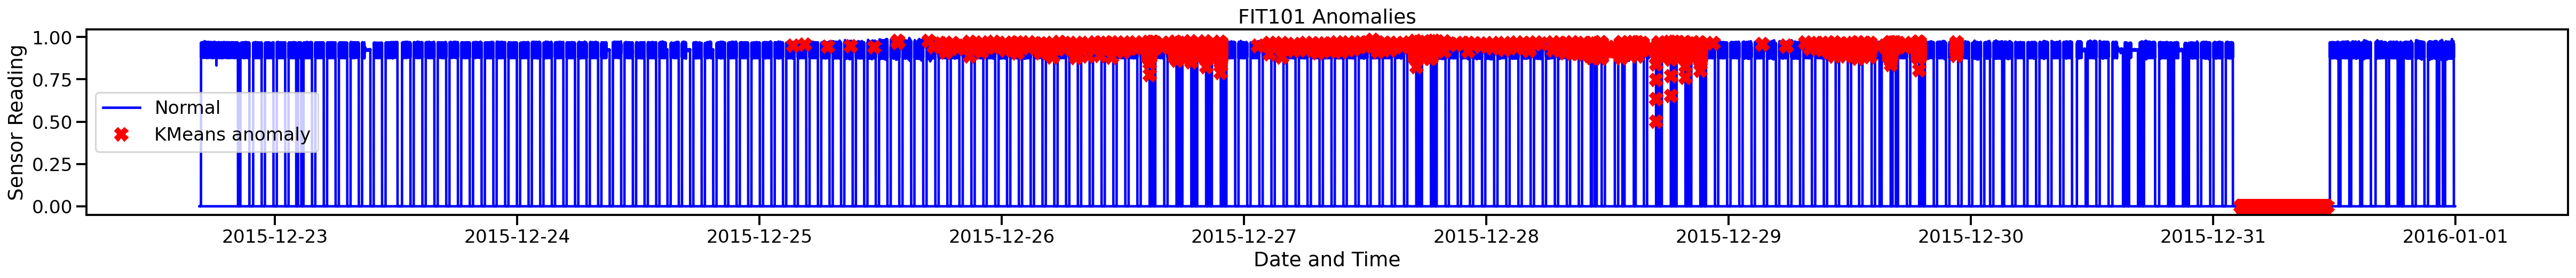

In [30]:
df['anomaly'] = pd.Series(principal_df['anomaly'].values, index=df.index)
a = df[df['anomaly'] == 1] #anomaly
_ = plt.figure(figsize=(40,3))
_ = plt.plot(df['FIT101'], color='blue', label='Normal')
_ = plt.plot(a['FIT101'], linestyle='none', marker='X', color='red', markersize=12, label='KMeans anomaly')
_ = plt.xlabel('Date and Time')
_ = plt.ylabel('Sensor Reading')
_ = plt.title('FIT101 Anomalies')
_ = plt.legend(loc='best')
plt.savefig('plots/anomaly.png', bbox_inches='tight')
plt.show()

### **KMeans evaluation**

In [31]:
predictions = df[['Machine_Status', 'anomaly']]
predictions.head()

,Machine_Status,anomaly
Timestamp,,
2015-12-28 10:00:00,0,0
2015-12-28 10:00:01,0,0
2015-12-28 10:00:02,0,0
2015-12-28 10:00:03,0,0
2015-12-28 10:00:04,0,0


In [32]:
report = classification_report(predictions['Machine_Status'], predictions['anomaly'])
print(report)

              precision    recall  f1-score   support

           0       0.98      0.99      0.98    755203
           1       0.78      0.63      0.70     49316

    accuracy                           0.97    804519
   macro avg       0.88      0.81      0.84    804519
weighted avg       0.96      0.97      0.96    804519



In [33]:
cm = confusion_matrix(predictions['Machine_Status'], predictions['anomaly'])

print('Confusion Matrix:')
print(cm)

Confusion Matrix:
[[746274   8929]
 [ 18020  31296]]


### **Isolation Forest**

In [34]:
from sklearn.ensemble import IsolationForest
model =  IsolationForest(contamination=anomaly_fraction)
model.fit(principal_df.values) 
principal_df['anomalyForest'] = pd.Series(model.predict(principal_df.values)) ###

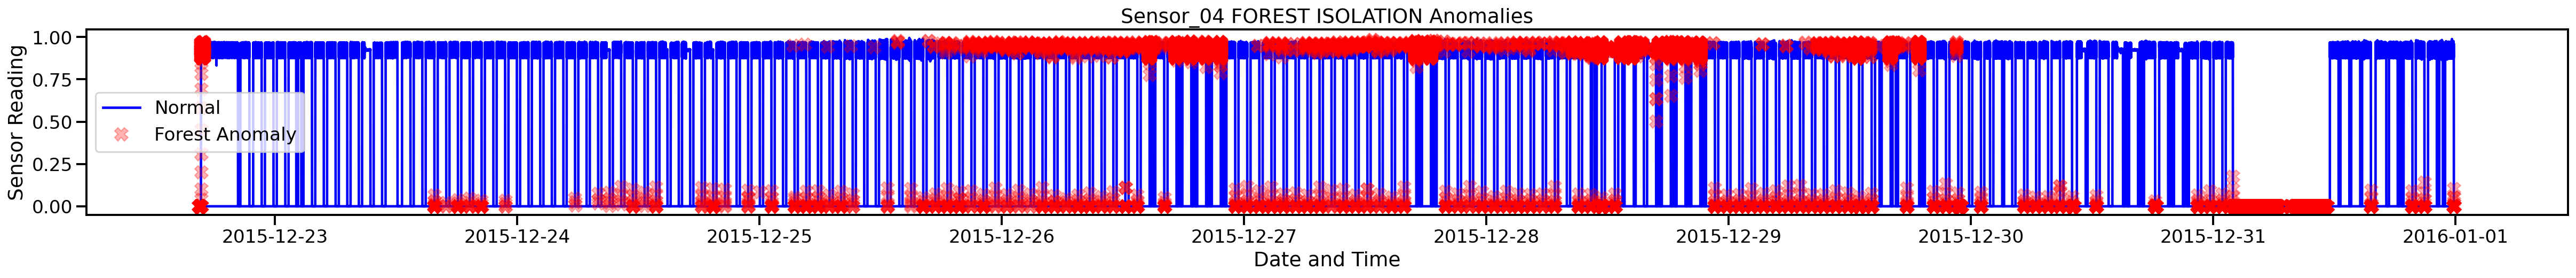

In [42]:
df['anomalyForest'] = pd.Series(principal_df['anomalyForest'].values, index=df.index)
a = df.loc[df['anomalyForest'] == -1] #anomaly
_ = plt.figure(figsize=(40,3))
_ = plt.plot(df['FIT101'], color='blue', label='Normal')
_ = plt.plot(a['FIT101'], linestyle='none', marker='X', color='red', markersize=12, label='Forest Anomaly', alpha=0.3)
_ = plt.xlabel('Date and Time')
_ = plt.ylabel('Sensor Reading')
_ = plt.title('Sensor_04 FOREST ISOLATION Anomalies')
_ = plt.legend(loc='best')
plt.show()

**Counting the values**

In [36]:
df['anomalyForest'].value_counts()

 1    764302
-1     40217
Name: anomalyForest, dtype: int64

In [37]:
df[df['anomalyForest']==1]['Machine_Status'].value_counts()


0    741677
1     22625
Name: Machine_Status, dtype: int64

In [38]:
df['Machine_Status'].value_counts()

0    755203
1     49316
Name: Machine_Status, dtype: int64